# Proportional Growth

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# install Pint if necessary

try:
    import pint
except ImportError:
    !pip install pint

In [2]:
# download modsim.py if necessary

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://raw.githubusercontent.com/AllenDowney/' +
         'ModSimPy/master/modsim.py')

In [3]:
# import functions from modsim

from modsim import *

This chapter is available as a Jupyter notebook where you can read the text, run the code, and work on the exercises. 
Click here to access the notebooks: <https://allendowney.github.io/ModSimPy/>.

Here's the data from the previous chapter again.

In [4]:
download('https://raw.githubusercontent.com/AllenDowney/' +
         'ModSimPy/master/data/World_population_estimates.html')

In [5]:
from pandas import read_html

filename = 'World_population_estimates.html'
tables = read_html(filename, header=0, index_col=0, decimal='M')
table2 = tables[2]
table2.columns = ['census', 'prb', 'un', 'maddison', 
                  'hyde', 'tanton', 'biraben', 'mj', 
                  'thomlinson', 'durand', 'clark']

In the previous chapter we simulated a model of world population with
constant growth. In this chapter we'll see if we can make a better model
with growth proportional to the population.

But first, we'll improve the code from the previous chapter by
encapsulating it in a function and adding a new feature, a `System` object.

## System Objects

Like a `State` object, a `System` object contains variables and their
values. The difference is:

-   `State` objects contain state variables that get updated in the course of a simulation.

-   `System` objects contain *system parameters*, which usually don't get updated over the course of a simulation.

For example, in the bike share model, state variables include the number of bikes at each location, which get updated whenever a customer moves a bike. System parameters include the number of locations, total number of bikes, and arrival rates at each location.

In the population model, the only state variable is the population.
System parameters include the annual growth rate, the initial population, and the start and end times.

Suppose we have the following variables, as computed in the previous
chapter (assuming `table2` is the `DataFrame` we read from the file):

In [6]:
un = table2.un / 1e9
census = table2.census / 1e9

t_0 = census.index[0]
t_end = census.index[-1]
elapsed_time = t_end - t_0

p_0 = census[t_0]
p_end = census[t_end]

total_growth = p_end - p_0
annual_growth = total_growth / elapsed_time

Some of these are parameters we need to simulate the system; others are temporary values we can discard. 
To distinguish between them, we'll put the parameters we need in a `System` object like this:

In [7]:
system = System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                annual_growth=annual_growth)

`t0` and `t_end` are the first and last years; `p_0` is the initial
population, and `annual_growth` is the estimated annual growth.

The assignment `t_0=t_0` reads the value of the existing variable named `t_0`, which we created previously, and stores it in a new system variable, also named `t_0`.
The variables inside the `System` object are distinct from other variables, so you can change one without affecting the other, even if they have the same name.

So this `System` object contains four new variables; here's what they look like.

In [8]:
show(system)

,value
t_0,1950.000000
t_end,2016.000000
p_0,2.557629
annual_growth,0.072248


Next we'll wrap the code from the previous chapter in a function:

In [9]:
def run_simulation1(system):
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in range(system.t_0, system.t_end):
        results[t+1] = results[t] + system.annual_growth
    
    return results

`run_simulation1` takes a `System` object and reads from it the values of `t_0`, `t_end`, and `annual_growth`.

It simulates population growth over time and returns the results in a `TimeSeries`.
Here's how we call it.

In [10]:
results1 = run_simulation1(system)

Here's the function we used in the previous chapter to plot the estimates.

In [11]:
def plot_estimates():
    census.plot(style=':', label='US Census')
    un.plot(style='--', label='UN DESA')
    decorate(xlabel='Year', 
             ylabel='World population (billion)') 

And here are the results.

/Users/brash/phys441/JupyterNotebooks/ModSimPy/chapters/modsim.py:534: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


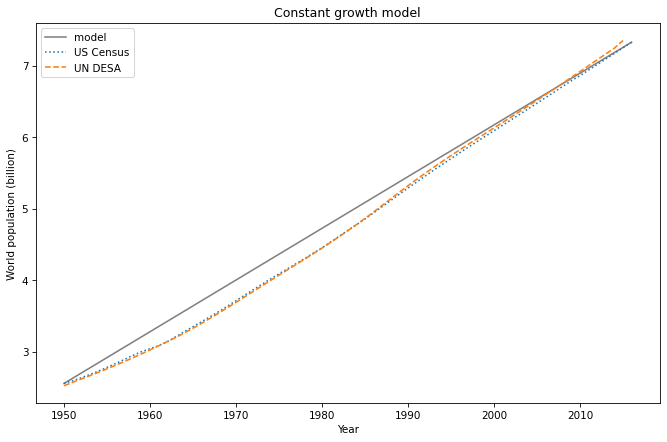

In [12]:
results1.plot(label='model', color='gray')
plot_estimates()
decorate(title='Constant growth model')

It might not be obvious that using functions and `System` objects is a
big improvement, and for a simple model that we run only once, maybe
it's not. But as we work with more complex models, and when we run many simulations with different parameters, we'll see that this way of organizing the code makes a big difference.

Now let's see if we can improve the model.

## Proportional Growth Model

The biggest problem with the constant growth model is that it doesn't
make any sense. It is hard to imagine how people all over the world
could conspire to keep population growth constant from year to year.

On the other hand, if some fraction of the population dies each year,
and some fraction gives birth, we can compute the net change in the
population like this:

In [13]:
def run_simulation2(system):
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in range(system.t_0, system.t_end):
        births = system.birth_rate * results[t]
        deaths = system.death_rate * results[t]
        results[t+1] = results[t] + births - deaths
        
    return results

Each time through the loop, we use the parameter `birth_rate` to compute the number of births, and `death_rate` to compute the number of deaths.
The rest of the function is the same as `run_simulation1`.

Now we can choose the values of `birth_rate` and `death_rate` that best fit the data. 
For the death rate, I'll use 7.7 deaths per 1000 people, which was roughly the global death rate in 2020 (see <https://www.indexmundi.com/world/death_rate.html>).
I chose the birth rate by hand to fit the population data.

In [14]:
system.death_rate = 7.7 / 1000
system.birth_rate = 25 / 1000

Then I ran the simulation and plotted the results:

/Users/brash/phys441/JupyterNotebooks/ModSimPy/chapters/modsim.py:534: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


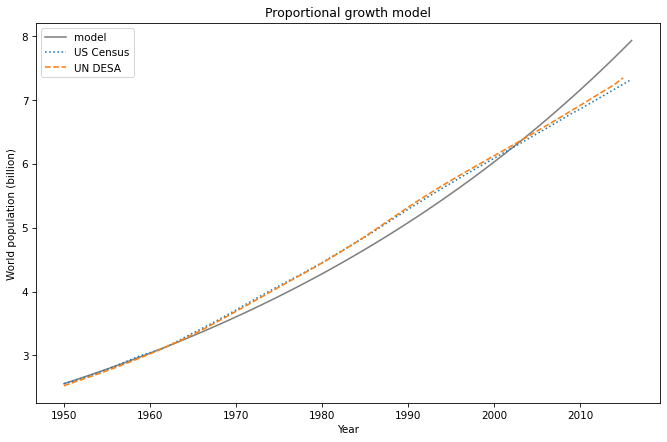

In [15]:
results2 = run_simulation2(system)
results2.plot(label='model', color='gray')
plot_estimates()
decorate(title='Proportional growth model')

The proportional model fits
the data well from 1950 to 1965, but not so well after that. Overall,
the *quality of fit* is not as good as the constant growth model,
which is surprising, because it seems like the proportional model is
more realistic.

In the next chapter we'll try one more time to find a model that makes
sense and fits the data. But first, I want to make a few more
improvements to the code.

## Factoring Out the Update Function

`run_simulation1` and `run_simulation2` are nearly identical except for the body of the `for` loop, where we compute the population for the next year.

Rather than repeat identical code, we can separate the things that
change from the things that don't. First, I'll pull out the births and deaths from `run_simulation2` and make a function:

In [16]:
def growth_func1(t, pop, system):
    births = system.birth_rate * pop
    deaths = system.death_rate * pop
    return births - deaths

`growth_func1` takes as arguments the current year, current population, and a `System` object; it returns the net population growth during the current year.

This function does not use `t`, so we could leave it out. But we will see other growth functions that need it, and it is convenient if they all take the same parameters, used or not.
Now we can write a function that runs any model:

In [17]:
def run_simulation(system, growth_func):
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in range(system.t_0, system.t_end):
        growth = growth_func(t, results[t], system)
        results[t+1] = results[t] + growth
        
    return results

This function demonstrates a feature we have not seen before: it takes a
function as a parameter! When we call `run_simulation`, the second
parameter is a function, like `growth_func1`, that computes the
population for the next year.

Here's how we call it:

In [18]:
results = run_simulation(system, growth_func1)

Passing a function as an argument is the same as passing any other
value. The argument, which is `growth_func1` in this example, gets
assigned to the parameter, which is called `growth_func`. Inside
`run_simulation`, we can call `growth_func` just like any other function.

Each time through the loop, `run_simulation` calls `growth_func1` to compute net growth, and uses it to compute the population during the next year.

## Combining Birth and Death

We can simplify the code slightly by combining births and deaths to compute the net growth rate. 
Instead of two parameters, `birth_rate` and `death_rate`, we can write the update function in terms of a single parameter that represents the difference:

In [19]:
system.alpha = system.birth_rate - system.death_rate

The name of this parameter, `alpha`, is the conventional name for a
proportional growth rate.

Here's the modified version of `growth_func1`:

In [20]:
def growth_func2(t, pop, system):
    return system.alpha * pop

And here's how we run it:

In [21]:
results = run_simulation(system, growth_func2)

The results are the same as the previous versions, but now the code is organized in a way that makes it easy to explore other models.

## Summary

In this chapter, we wrapped the code from the previous chapter in functions and used a `System` object to store the parameters of the system.

We explored a new model of population growth, where the number of births and deaths is proportional to the current population.  This model seems more realistic, but it turns out not to fit the data particularly well.

In the next chapter, we'll try one more model, which is based on the assumption that the population can't keep growing forever.
But first, you might want to work on some exercises.

## Exercises

### Exercise 1

 Maybe the reason the proportional model doesn't work very well is that the growth rate, `alpha`, is changing over time.  So let's try a model with different growth rates before and after 1980 (as an arbitrary choice).

Write an update function that takes `t`, `pop`, and `system` as parameters.  The system object, `system`, should contain two parameters: the growth rate before 1980, `alpha1`, and the growth rate after 1980, `alpha2`.  It should use `t` to determine which growth rate to use.

Test your function by calling it directly, then pass it to `run_simulation`.  Plot the results.  Adjust the parameters `alpha1` and `alpha2` to fit the data as well as you can.

In [22]:
system.alpha1 = system.birth_rate - system.death_rate + 0.001
system.alpha2 = system.birth_rate - system.death_rate - 0.0053

def growth_func2(t, pop, system):
    if t < 1994:
        return system.alpha1 * pop
    else:
        return system.alpha2 * pop

In [23]:
results3 = run_simulation(system, growth_func2)

/Users/brash/phys441/JupyterNotebooks/ModSimPy/chapters/modsim.py:534: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


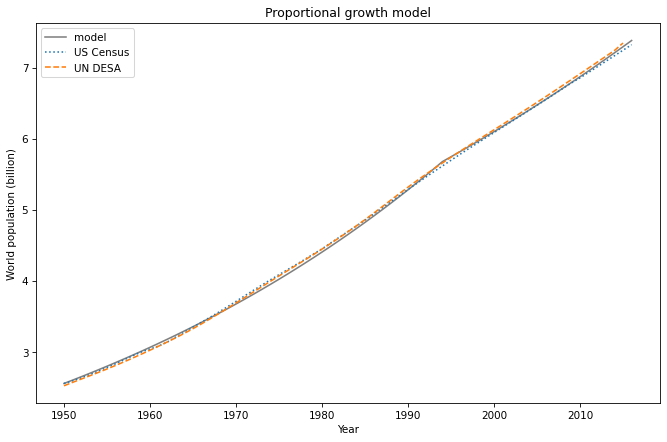

In [24]:
results3.plot(label='model', color='gray')
plot_estimates()
decorate(title='Proportional growth model')

## Under the Hood

The `System` object defined in the ModSim library, is based on the `SimpleNamespace` object defined in a standard Python library called `types`; the documentation is at <https://docs.python.org/3.7/library/types.html#types.SimpleNamespace>.